In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

# Linear softmax policy

In [5]:
from agents import Agent
from mouselab_policy import MouselabPolicy
from mouselab import MouselabEnv
from mouselab_utils import make_envs

agent = Agent()
env = make_envs(n=1)[0]
theta = np.ones(8)
weights = {
    'is_term': 10,
    'term_reward': 1,
    'voi_myopic': 1,
    'vpi_action': 1,
    'vpi_full': 1,
}
pol = MouselabPolicy(weights, temp=1)
agent.register(env)
agent.register(pol)

# Optimized LC policy

In [6]:
import numpy as np
from agents import Agent
from mouselab_policy import MouselabPolicy
from mouselab import MouselabEnv
from mouselab_utils import make_envs, get_util
from skopt import gp_minimize
from joblib import Parallel, delayed
from contexttimer import Timer

def lc_policy(x, normalize_voi=True):
    x = np.array(x)
    assert len(x) == 4, x
    voi = x[1:]
    if normalize_voi and voi.sum():
        voi /= voi.sum()
    # Note: an `is_term` feature is functionally equivalent to a `cost` feature
    # when all clicks have the same cost.
    weights = dict(zip(['is_term', 'voi_myopic', 'vpi_action', 'vpi_full'], x))
    return MouselabPolicy(weights)


def avg_utility(x,train_envs):
    with Timer() as t:
        util = get_util(lc_policy(x), train_envs)
        xs =  np.array2string(np.array(x), 
                              formatter={'float_kind': lambda x: f'{x: 6.2f}'})
        print(f'{xs} -> {util:6.3f}  ({t.elapsed:2.1f} seconds)')
    return util

bounds = [
    (-30., 30.), # is_term
    (0., 1.),    # voi_myopic
    (0., 1.),    # vpi_action
    (0., 1.),    # vpi_full
]


environments = ["constant_high","constant_low","increasing","decreasing"]

cost = 1.00
def write_policy(env_type, seed):
    print(env_type, seed)
    envs = make_envs(cost, 100, seed, env_type)
    def loss(x):
        return - avg_utility(x,envs) 
    
    result = gp_minimize(loss, bounds, n_calls=50, random_state=seed)
    result.specs['args'].pop('func')  # can't pickle
    pol = lc_policy(result.x)
    joblib.dump(result, f'data/gp_results/{env_type}_{seed}.pkl')
    joblib.dump(pol, f'data/policies/{env_type}_{seed}.pkl')

jobs = [delayed(write_policy)(et, seed)
                for et in environments
                for seed in range(1,5)]
results = Parallel(n_jobs=16)(jobs)

[ 28.02   0.55   0.97   0.71] ->  1.500  (0.8 seconds)
[ 28.02   0.55   0.97   0.71] ->  0.075  (4.1 seconds)
[  3.05   0.71   0.29   0.51] ->  0.039  (4.2 seconds)
[ 28.02   0.55   0.97   0.71] ->  1.445  (4.3 seconds)
[ 11.86   0.22   0.98   0.01] ->  0.075  (0.9 seconds)
[ 23.58   0.90   0.13   0.21] ->  0.039  (0.8 seconds)
[ 11.86   0.22   0.98   0.01] ->  1.445  (0.8 seconds)
[ 11.86   0.22   0.98   0.01] -> 17.450  (6.8 seconds)


KeyboardInterrupt: 

In [47]:
!ls data
#np.save('data/LC_policy_by_environment.npy',LC_policies)

envs.pkl


In [20]:
test_envs = make_envs(1.25, n=100)


training_set_performance = get_util(opt_pol,train_envs)
test_set_performance = get_util(opt_pol,test_envs)



NameError: name 'opt_pol' is not defined

In [11]:
training_set_performance

21.600000000000001

In [13]:
test_set_performance

24.0

In [21]:
from agents import run_episode
from model_utils import render_trace

env = make_envs(n=1)[0]
trace = run_episode(opt_pol, env)
render_trace(trace,env)

NameError: name 'opt_pol' is not defined

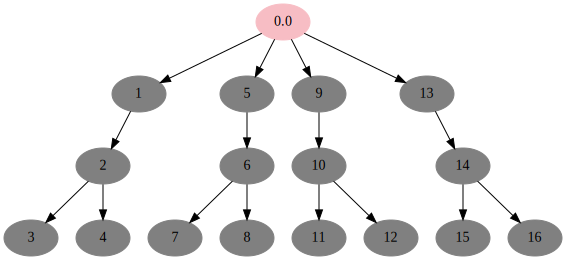

In [17]:
env.reset()
env.render()

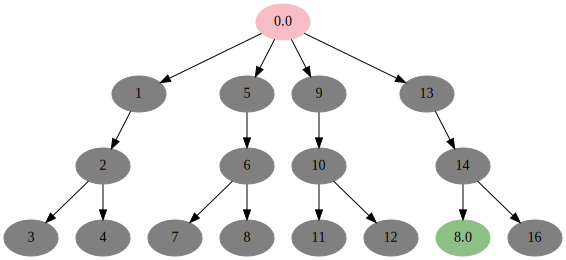

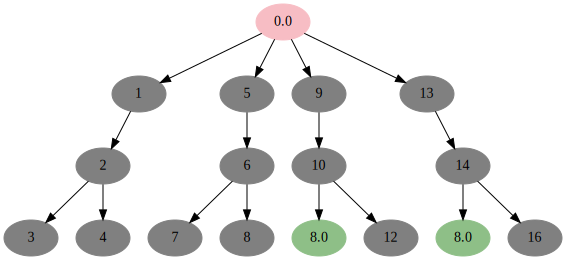

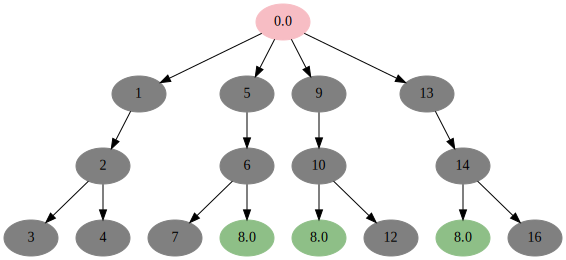

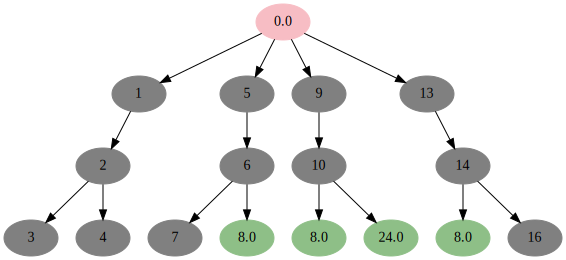

[15, 11, 8, 12, 17]


In [26]:
env = make_envs(10,1,None,"increasing")[0]
trace = run_episode(LC_policies["increasing"], env)


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 

print(trace['actions'])    
#env.render()    
#env.render()
#trace['actions'][0]

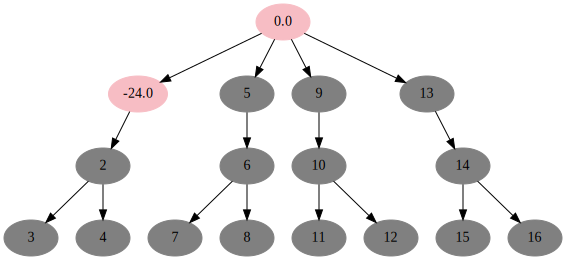

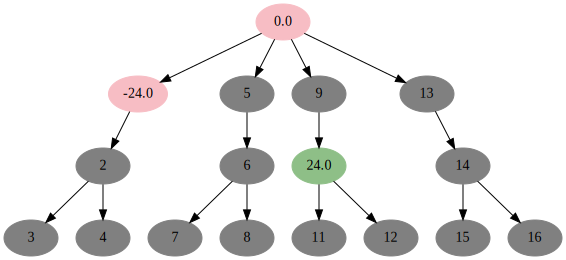

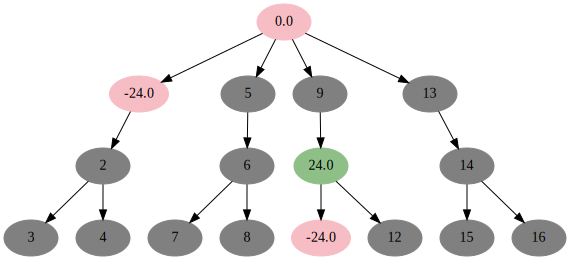

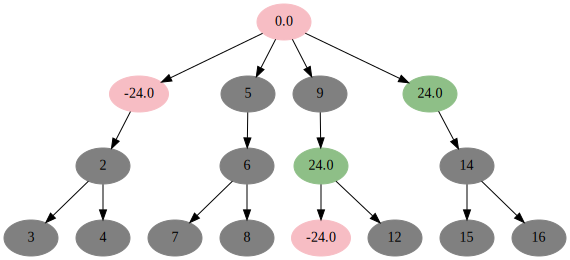

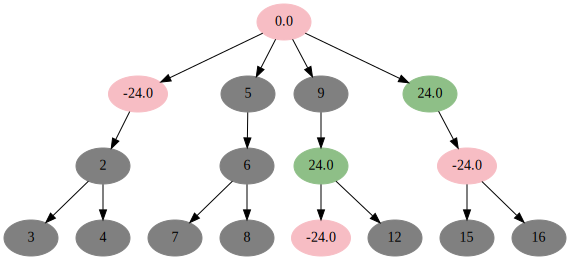

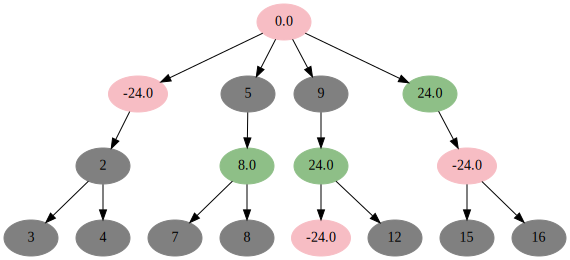

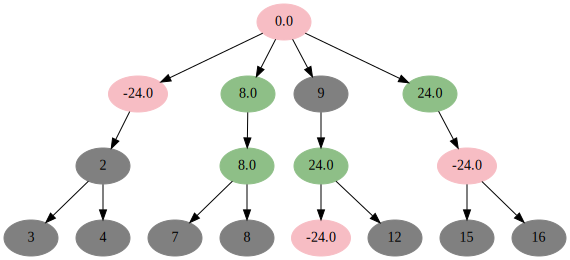

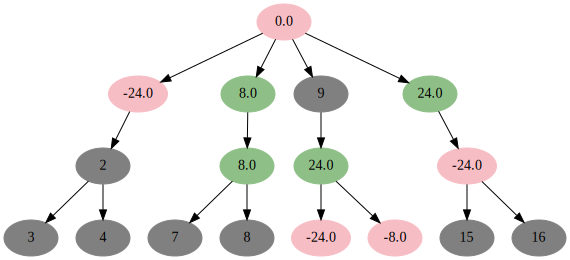

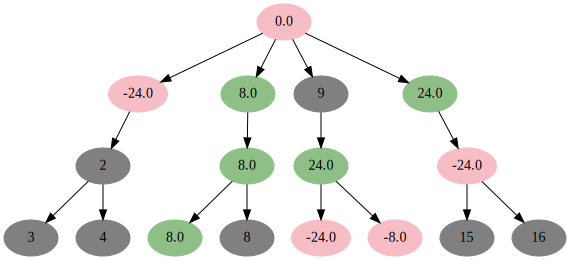

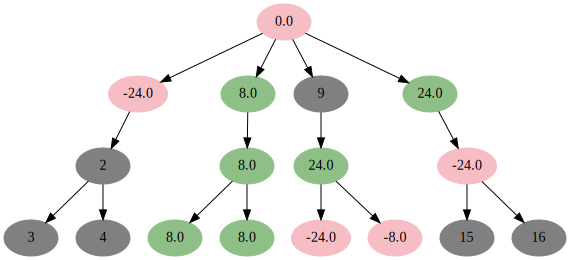

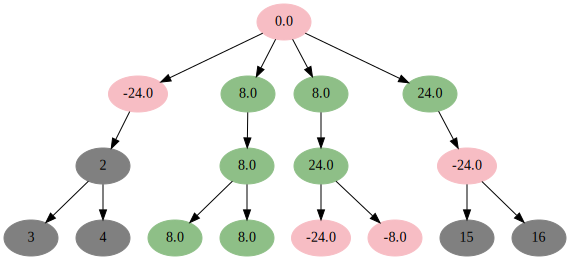

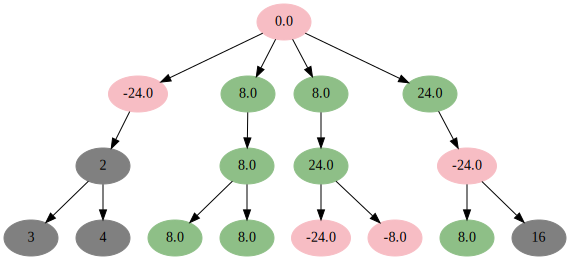

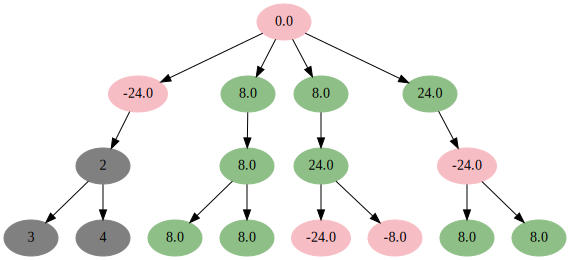

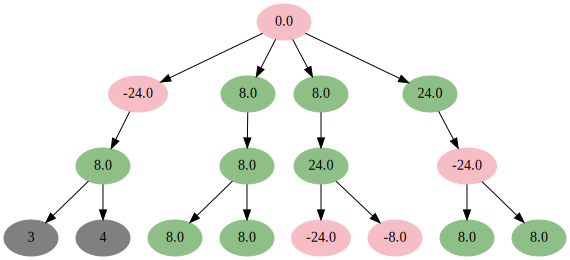

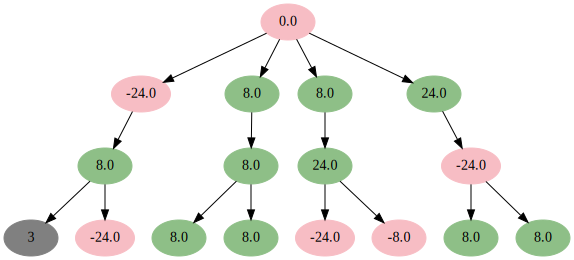

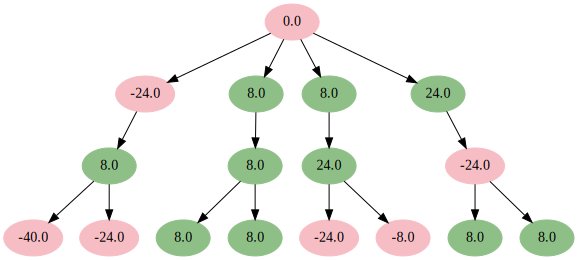

[1, 10, 11, 13, 14, 6, 5, 12, 7, 8, 9, 15, 16, 2, 4, 3, 17]


In [32]:
env = make_envs(10,1,None,"constant_high")[0]
trace = run_episode(LC_policies["constant_high"], env)


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 

print(trace['actions'])    
#env.render()    
#env.render()
#trace['actions'][0]

In [34]:
env = make_envs(10,1,None,"constant_low")[0]
trace = run_episode(LC_policies["constant_low"], env)


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 

print(trace['actions'])    
#env.render()    
#env.render()
#trace['actions'][0]

[17]


In [35]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

COSTS = [0.1, 0.5, 1, 1.25, 2, 4.]
term_action = 17

def eval_envs(cost, envs):
    policies = {
        'BO': LC_policies[cost],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                yield df
    return pd.concat(loop())



envs_per_cost = 100
chunks_per_job = 5
total_envs = envs_per_cost * len(COSTS)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)


jobs = [delayed(eval_envs)(cost_var, envs) 
        for cost_var in COSTS
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost_var, envs_per_cost))]
result = Parallel(n_job)(tqdm(jobs))

  1%|          | 1/150 [00:01<03:42,  1.49s/it]

JoblibKeyError: JoblibKeyError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fe244b39390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/falklieder/miniconda3/envs/mcrl/lib/python...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/falkli.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fe244b39390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/falklieder/miniconda3/envs/mcrl/lib/python...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/falkli.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 7, 19, 49, 8, 456699, tzinfo=tzlocal()), 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'session': '10183E29DC1246E782F28FEFDBB7BE4C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'10183E29DC1246E782F28FEFDBB7BE4C']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 7, 19, 49, 8, 456699, tzinfo=tzlocal()), 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'session': '10183E29DC1246E782F28FEFDBB7BE4C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'10183E29DC1246E782F28FEFDBB7BE4C'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 7, 19, 49, 8, 456699, tzinfo=tzlocal()), 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'session': '10183E29DC1246E782F28FEFDBB7BE4C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '833F9065F7E740DC92C9180883D9F718', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from evaluation import *\nfrom model_utils import..._per_cost))]\nresult = Parallel(n_job)(tqdm(jobs))', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Import object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-35-5c345ad98ddb>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fe18631e198, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fe1685ac150, file "<ipython-input-35-5c345ad98ddb>", line 43>
        result = <ExecutionResult object at 7fe18631e198, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fe1685ac150, file "<ipython-input-35-5c345ad98ddb>", line 43>, result=<ExecutionResult object at 7fe18631e198, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fe1685ac150, file "<ipython-input-35-5c345ad98ddb>", line 43>
        self.user_global_ns = {'Agent': <class 'agents.Agent'>, 'COSTS': [0.1, 0.5, 1, 1.25, 2, 4.0], 'Categorical': <class 'distributions.Categorical'>, 'Counter': <class 'collections.Counter'>, 'ENV': <mouselab.MouselabEnv object>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'FunctionPolicy': <class 'policies.FunctionPolicy'>, 'In': ['', "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "get_ipython().run_line_magic('matplotlib', 'inli...ation import get_util\n# from model_utils import *", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', "# Need the `dot` command from graphviz to visual...+=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "get_ipython().run_line_magic('matplotlib', 'inli...ation import get_util\n# from model_utils import *", "# Need the `dot` command from graphviz to visual...+=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', '# env._term_reward() gives the true termination ...n agent should \n# not have access to that method.', "from mouselab_policy import MouselabPolicy\n\nagen...atures for each action in the state shown above')", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", 'LC_policies', ...], 'LC_policies': {'constant_high': <mouselab_policy.MouselabPolicy object>, 'constant_low': <mouselab_policy.MouselabPolicy object>, 'increasing': <mouselab_policy.MouselabPolicy object>}, 'Labeler': <class 'utils.Labeler'>, ...}
        self.user_ns = {'Agent': <class 'agents.Agent'>, 'COSTS': [0.1, 0.5, 1, 1.25, 2, 4.0], 'Categorical': <class 'distributions.Categorical'>, 'Counter': <class 'collections.Counter'>, 'ENV': <mouselab.MouselabEnv object>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'FunctionPolicy': <class 'policies.FunctionPolicy'>, 'In': ['', "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "get_ipython().run_line_magic('matplotlib', 'inli...ation import get_util\n# from model_utils import *", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', "# Need the `dot` command from graphviz to visual...+=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "get_ipython().run_line_magic('matplotlib', 'inli...ation import get_util\n# from model_utils import *", "# Need the `dot` command from graphviz to visual...+=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'", 'from mouselab import MouselabEnv\nfrom distributi...for a in [1, 5, 6,]:\n    env.step(a)\nenv.render()', '# env._term_reward() gives the true termination ...n agent should \n# not have access to that method.', "from mouselab_policy import MouselabPolicy\n\nagen...atures for each action in the state shown above')", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", "from contexttimer import Timer\n\n#COSTS = [0.1,0....('data/LC_policy_by_environment.npy',LC_policies)", 'LC_policies', ...], 'LC_policies': {'constant_high': <mouselab_policy.MouselabPolicy object>, 'constant_low': <mouselab_policy.MouselabPolicy object>, 'increasing': <mouselab_policy.MouselabPolicy object>}, 'Labeler': <class 'utils.Labeler'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/falklieder/MCRL/python/<ipython-input-35-5c345ad98ddb> in <module>()
     38 
     39 jobs = [delayed(eval_envs)(cost_var, envs) 
     40         for cost_var in COSTS
     41             for envs in partition_all(envs_per_chunk, 
     42                                   make_envs(cost_var, envs_per_cost))]
---> 43 result = Parallel(n_job)(tqdm(jobs))

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=26), iterable=  1%|          | 1/150 [00:01<04:05,  1.65s/it])
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=26)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
KeyError                                           Sun Jan  7 19:49:17 2018
PID: 73165   Python 3.6.3: /home/falklieder/miniconda3/envs/mcrl/bin/python
...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function eval_envs>, (0.1, (<mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>)), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function eval_envs>
        args = (0.1, (<mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>))
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/falklieder/MCRL/python/<ipython-input-35-5c345ad98ddb> in eval_envs(cost=0.1, envs=(<mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>))
     11 COSTS = [0.1, 0.5, 1, 1.25, 2, 4.]
     12 term_action = 17
     13 
     14 def eval_envs(cost, envs):
     15     policies = {
---> 16         'BO': LC_policies[cost],
     17         'full-observation': FixedPlanPolicy(range(1, term_action+1)),
     18         'none': FixedPlanPolicy([term_action]),
     19     }
     20     def loop():

KeyError: 0.1
___________________________________________________________________________

In [46]:
term_action = 17

def eval_envs(cost, env_type, envs):
    policies = {
        'BO': LC_policies[env_type],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                df['env_type'] = env_type
                yield df
    return pd.concat(loop())


envs_per_cost = 100
chunks_per_job = 5
total_envs = envs_per_cost * len(COSTS)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)

environments=['increasing','constant_low','constant_high']

cost = 1.00
jobs = [delayed(eval_envs)(cost, env_type, envs) 
        for env_type in environments
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost, envs_per_cost,None, env_type))]
result = Parallel(n_job)(tqdm(jobs))



  0%|          | 0/75 [00:00<?, ?it/s]


  1%|▏         | 1/75 [00:01<01:53,  1.53s/it]

 69%|██████▉   | 52/75 [00:03<00:01, 16.30it/s]

 71%|███████   | 53/75 [00:03<00:01, 14.62it/s]

 72%|███████▏  | 54/75 [00:03<00:01, 14.15it/s]

 75%|███████▍  | 56/75 [00:03<00:01, 14.23it/s]

 77%|███████▋  | 58/75 [00:04<00:01, 14.28it/s]

 81%|████████▏ | 61/75 [00:04<00:01, 13.75it/s]

 87%|████████▋ | 65/75 [00:04<00:00, 14.29it/s]

 92%|█████████▏| 69/75 [00:04<00:00, 14.83it/s]

 96%|█████████▌| 72/75 [00:04<00:00, 14.94it/s]

100%|██████████| 75/75 [00:05<00:00, 14.89it/s]



In [47]:
results = pd.concat(result)

pd.concat(result).to_pickle('data/eval_envs_backward_planning.pkl')

#LC_policies.to_pickle('data/LC_policies_backward_planning.pkl')

#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

#results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','env_type']).util.mean())
print(results.groupby(['agent','env_type']).observations.mean())

results

#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

agent             env_type     
BO                constant_high    34.048667
                  constant_low      0.053000
                  increasing       18.427200
full-observation  constant_high    30.880000
                  constant_low    -13.672000
                  increasing        9.760000
none              constant_high     2.780000
                  constant_low      0.053000
                  increasing       -0.168000
Name: util, dtype: float64
agent             env_type     
BO                constant_high     8.132667
                  constant_low      0.000000
                  increasing        5.114667
full-observation  constant_high    16.000000
                  constant_low     16.000000
                  increasing       16.000000
none              constant_high     0.000000
                  constant_low      0.000000
                  increasing        0.000000
Name: observations, dtype: float64


,observations,util,env,agent,cost,env_type
0,3,18.6,<MouselabEnv instance>,BO,1.0,increasing
1,2,16.4,<MouselabEnv instance>,BO,1.0,increasing
2,2,37.2,<MouselabEnv instance>,BO,1.0,increasing
3,16,-10.4,<MouselabEnv instance>,BO,1.0,increasing
0,1,20.6,<MouselabEnv instance>,BO,1.0,increasing
1,4,14.4,<MouselabEnv instance>,BO,1.0,increasing
2,1,47.8,<MouselabEnv instance>,BO,1.0,increasing
3,16,-10.4,<MouselabEnv instance>,BO,1.0,increasing
0,8,13.6,<MouselabEnv instance>,BO,1.0,increasing
1,3,15.4,<MouselabEnv instance>,BO,1.0,increasing


In [ ]:
# Plot results - Fred
results = pd.read_pickle('data/eval_envs_backward_planning.pkl')
g = sns.factorplot('env_type', 'util', hue='agent', kind='bar', data=results)
g.set_xticklabels(rotation=30)

In [177]:
print(LC_policies[0.1].weights)
print('\n')
print(LC_policies[1.25].weights)
print('\n')
print(LC_policies[4.0].weights)


OrderedDict([('is_term', -28.786896153580457), ('term_reward', 1), ('voi_myopic', 0.33562706510652707), ('vpi_action', 0.31367312214646487), ('vpi_full', 0.35069981274700812), ('quality_ev', 0), ('quality_std', 0), ('depth', 0)])


OrderedDict([('is_term', -4.5807120396657126), ('term_reward', 1), ('voi_myopic', 0.32699288636171941), ('vpi_action', 0.22153461744122863), ('vpi_full', 0.45147249619705193), ('quality_ev', 0), ('quality_std', 0), ('depth', 0)])


OrderedDict([('is_term', 2.9288102356394887), ('term_reward', 1), ('voi_myopic', 0.38392504493015067), ('vpi_action', 0.32357298237576188), ('vpi_full', 0.29250197269408745), ('quality_ev', 0), ('quality_std', 0), ('depth', 0)])


In [48]:
#Save Data

for c in COSTS:
    weights[c]=LC_policies[c].weights

np.save('data/LC_policy_weights_backward_planning.npy',weights)
np.save('data/results_backward_planning.npy',results)

KeyError: 0.1

In [38]:
environments = ["constant_high","constant_low","increasing"]

for env in environments:
    weights[env] = LC_policies[env].weights

np.save('data/weights_by_environment.npy',weights)
np.save()